Code is adapted from class CNN notebook, and the following tutorial https://www.kaggle.com/code/songseungwon/cyclegan-tutorial-from-scratch-monet-to-photo/notebook .

## Main file for Styletransfer, with VGG excluded.

### Data preprocessing 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import glob

In [ ]:
# Munch data preprocessing, only need to run once
########################################
# make sure the data are downloaded from 
# https://www.kaggle.com/code/isaienkov/how-to-start-with-munch-s-paintings
# and set fileDir to the folder
########################################
# Monet painting data are from 
# https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings/notebook
# already cleaned and reshaped

# # This is the directory of the unzipped file you download
# fileDir = "../../../Desktop/NU/Deep_Learning/archive/"
# imgIndex = pd.read_csv(fileDir + "/edvard_munch.csv")
# fileList = imgIndex["filename"]

# # load each individual image, resize and save
# processDir = fileDir + "/munch_processed"
# if not os.path.exists(processDir):
#     os.makedirs(processDir)


In [ ]:
# Prepare Pytorch dataset

class MyDataset(torch.utils.data.Dataset): 
    def __init__(self, MunchDir, MonetDir, MunchName, MonetName, transform=None, target_transform=None): 
        imgs = []                      
        for name in MunchName:
            imgs.append((name,1))
        for name in MonetName:
            imgs.append((name,0))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
 
    def __getitem__(self, index):  
        fn, label = self.imgs[index]
        if label == 1:
            img = Image.open(MunchDir + '/' + fn).convert('RGB')
        if label == 0:
            img = Image.open(MonetDir + '/' + fn).convert('RGB')
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
 
    def __len__(self): 
        return len(self.imgs)


In [ ]:
# training and testing preperation

# Munch processed image
MunchDir = "/kaggle/input/all-image/archive/munch_processed"
MunchFileName = np.array(os.listdir(MunchDir))

# Monet processed image
MonetDir = "/kaggle/input/all-image/archive/monet_processed"
MonetFileName = np.array(os.listdir(MonetDir))

# training set size
np.random.seed(100)
trainRatio = 0.7

trainMunchIdx = np.random.choice(len(MunchFileName), int(trainRatio * len(MunchFileName)), replace=False)
trainMonetIdx = np.random.choice(len(MonetFileName), int(trainRatio * len(MonetFileName)), replace=False)

trainMunch = MunchFileName[trainMunchIdx]
trainMonet = MonetFileName[trainMonetIdx]

testMunch = np.delete(MunchFileName, trainMunchIdx)
testMonet = np.delete(MonetFileName, trainMonetIdx)


# Style Transfer

In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import glob

In [2]:
!cat /proc/cpuinfo | grep processor
n_cpu = 2

processor	: 0
processor	: 1


In [3]:
# data (path)
dataset_name = 'gan-getting-started'
root = '../input/'+dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 100 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

In [6]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [7]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [8]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [10]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [11]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [12]:
G_AB.apply(temp_weights_init_normal);

ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPa

In [13]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [14]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [15]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [16]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  """
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [17]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [20]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join("/kaggle/input/allData2/archive2/monet_processed")+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join("/kaggle/input/allData2/archive2/grey")+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join("/kaggle/input/allData2/archive2/monet_processed")+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join("/kaggle/input/allData2/archive2/grey")+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [21]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

In [22]:
import matplotlib.pyplot as plt

In [23]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [24]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

In [25]:
temp_imgs = next(iter(val_dataloader))

In [26]:
G_AB.eval() # test mode 
G_BA.eval() # test mode
# print(temp_imgs['A'].shape)
# print(temp_imgs['B'].shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [27]:
temp_real_A = temp_imgs['A'].type(Tensor) # A : monet
temp_fake_B = G_AB(temp_real_A).detach()
temp_real_B = temp_imgs['B'].type(Tensor) # B : photo
temp_fake_A = G_BA(temp_real_B).detach()

In [28]:
temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

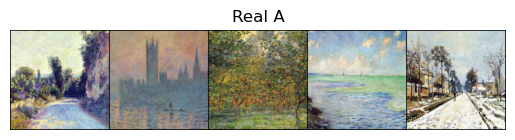

In [30]:
plt.imshow(temp_real_A.cpu().permute(1,2,0))
plt.title('Real A')
plt.axis('off');

In [32]:
temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
print(temp_image_grid.shape)

torch.Size([3, 1040, 1292])


In [33]:
temp_image_grid.cpu().permute(1,2,0).shape

torch.Size([1040, 1292, 3])

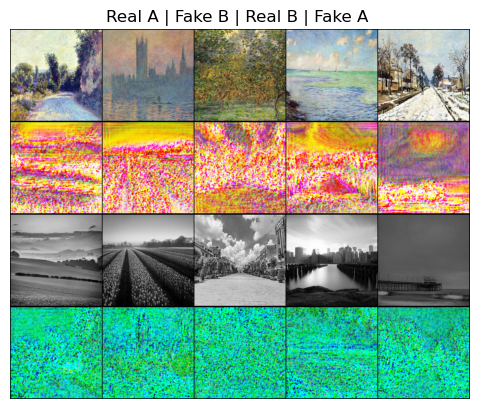

In [34]:
plt.imshow(temp_image_grid.cpu().permute(1,2,0))
plt.title('Real A | Fake B | Real B | Fake A ')
plt.axis('off');

In [35]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

In [2]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 50 == 0:
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))

In [ ]:
for i, batch in enumerate(dataloader):
    print('iter : {}  A.size : {}'.format(i,batch['A'].size()))
    print('iter : {}  B.size : {}'.format(i,batch['B'].size()))
    if i == 10:
        break